In [1]:
import sys, os
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapl'] + '/azav')

import numpy as np
import scipy as sp
import pickle

import matplotlib.pyplot as plt

%matplotlib notebook

from azav_util import *
from plotcommon import *
from common import *

In [2]:
# Get Rachel's solar data
di = get_dict('gongdata/avgong1995-2009rls.pkl')
di.keys()

dict_keys(['om', 'om_err', 'nt', 'nr', 'tt', 'rr', 'sint', 'cost', 'rr_2d', 'tt_2d', 'sint_2d', 'cost_2d', 'xx', 'zz'])

In [3]:
# read in model S
fname = os.environ['notes'] + '/Model_S/Model_S.pkl'
model_S = get_dict(fname)
model_S.keys()

dict_keys(['msun', 'rsun', 'lsun', 'zsun', 'x0sun', 'alphasun', 'agesun', 'rr', 'lnq', 'grav', 'tmp', 'prs', 'rho', 'xfrac', 'lum', 'opa', 'eps', 'gamma', 'gamma_ad', 'delta', 'c_p', 'mue', 'ne', 'dsdr', 'nsq', 'zfrac', 'nu', 'kappa', 'eta', 'prm', 'pr', 'drhodr', 'dtmpdr', 'dprsdr', 'dlnrho', 'dlntmp', 'dlnprs', 'gas_constant', 'ircut', 'rcut', 'irbcz', 'rbcz', 'frad', 'heat', 'rtach', 'dtach', 'irtach', 'irtach1', 'irtach2', 'rtach1', 'rtach2'])

In [4]:
# cut the data off below 0.5*rsun (like in Rachel's plot)
rbot = 0.5*model_S['rsun']

In [5]:
print("common:  ", rsun)
print("model S: ", model_S['rsun'])
print("GONG   : ", np.max(di['rr']))

common:   69570000000.0
model S:  69599062580.0
GONG   :  1.00071


In [6]:
# they're a bit different... use model_S rsun for consistency
rsun = model_S['rsun']

In [7]:
# diffrot in "lab" frame
Om_nhz = di['om']
Om_err_nhz = di['om_err']

Om = Om_nhz*1e-9*(2*np.pi) # nHz --> rad/s

nt = di['nt']
nr = di['nr']

tt = di['tt']
tt_lat = 180./np.pi*(np.pi/2-tt)
rr = di['rr']*rsun

cost = di['cost']
sint = di['sint']

cost_2d = di['cost_2d']
sint_2d = di['sint_2d']

rr_2d = di['rr_2d']*rsun

xx = di['xx']
zz = di['zz']

In [8]:
rr_2d[1,:]

array([6.96484779e+10, 6.96310781e+10, 6.96122864e+10, 6.95893883e+10,
       6.95584863e+10, 6.95184669e+10, 6.94687731e+10, 6.94077348e+10,
       6.93323590e+10, 6.92377042e+10, 6.91161147e+10, 6.89563152e+10,
       6.87407669e+10, 6.84568724e+10, 6.81073459e+10, 6.76866891e+10,
       6.71852975e+10, 6.65992734e+10, 6.59272248e+10, 6.51674815e+10,
       6.43180249e+10, 6.33767672e+10, 6.23410635e+10, 6.12083388e+10,
       5.99752522e+10, 5.86382542e+10, 5.71933081e+10, 5.56356811e+10,
       5.39595964e+10, 5.21587207e+10, 5.02255371e+10, 4.81567746e+10,
       4.59759576e+10, 4.36949179e+10, 4.13165787e+10, 3.88404529e+10,
       3.62629212e+10, 3.35780677e+10])

In [9]:
# make sure all the shapes and ordering (decreasing coordinates)
# is hunky-dory

In [10]:
print(np.shape(Om))
print(np.shape(tt))
print(np.shape(rr))
print(np.shape(rr_2d))
print(np.shape(sint_2d))
print(np.min(rr)/rsun, np.max(rr)/rsun)
print(np.min(tt), np.max(tt))

(41, 38)
(41,)
(38,)
(41, 38)
(41, 38)
0.48245 1.00071
0.261799 1.5708


<IPython.core.display.Javascript object>


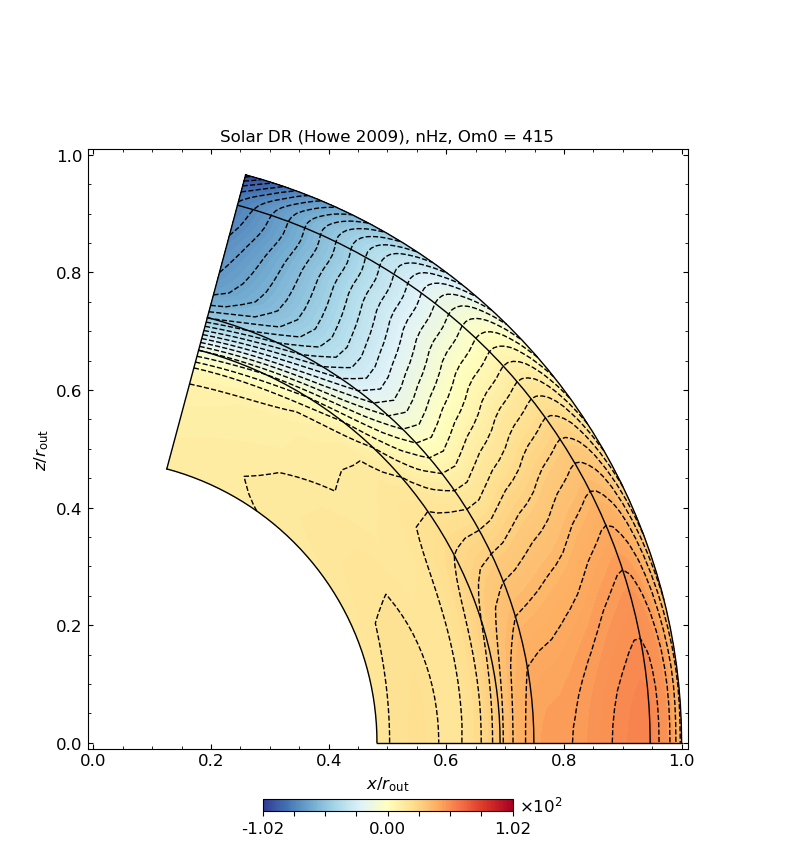

Text(0.5, 1.0, 'Solar DR (Howe 2009), nHz, Om0 = 415')

In [11]:
# plot the DR to make sure it looks good
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 6, 'ncontours': 20, 'plotcontours': True,\
                     'rvals': np.array([0.695,0.745,0.95])*rsun})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]

Om0 = 415
plot_azav (Om/(2*np.pi)*1e9-Om0, rr, cost, fig, ax, **kw_plot_azav)

ax.set_title("Solar DR (Howe 2009), nHz, Om0 = %i" %Om0)
#plt.savefig('images/solar_diffrot_full.png', dpi=300)

In [12]:
# get rotation rate derivatives
dOmdr = np.gradient(Om, rr, axis=1)
dOmdt = np.gradient(Om, tt, axis=0)/rr_2d
dOmdz = cost_2d*dOmdr - sint_2d*dOmdt
dOmdl = sint_2d*dOmdr + cost_2d*dOmdt

In [13]:
# interpolate model S onto radial grid

In [14]:
rr_model_S = model_S['rr']

y = model_S['grav']
f = sp.interpolate.interp1d(rr_model_S, y)
grav = f(rr)

y = model_S['c_p']
f = sp.interpolate.interp1d(rr_model_S, y)
c_p = f(rr)

y = model_S['tmp']
f = sp.interpolate.interp1d(rr_model_S, y)
tmp = f(rr)

y = model_S['rho']
f = sp.interpolate.interp1d(rr_model_S, y)
rho = f(rr)

y = model_S['prs']
f = sp.interpolate.interp1d(rr_model_S, y)
prs = f(rr)

y = model_S['delta'] # -dlnrho/dlntmp
f = sp.interpolate.interp1d(rr_model_S, y)
delta = f(rr)

y = model_S['dlntmp']/model_S['dlnprs'] # -dlnrho/dlntmp
f = sp.interpolate.interp1d(rr_model_S, y)
dtdp = f(rr)

y = model_S['dsdr']/model_S['dlnprs'] # -dlnrho/dlntmp
f = sp.interpolate.interp1d(rr_model_S, y)
dsdp = f(rr)/c_p

In [15]:
#help(np.trapz)
inds_from_vals(rr, [rsun, 0.95*rsun])

array([ 3, 18])

In [16]:
# integration and "priming" functions
def integrate_from_equator(arr):
    int_arr = np.zeros((nt, nr))
    for it in range(nt):
        int_arr[it, :] = np.trapz(arr[:it+1, :], tt[:it+1], axis=0)
    return int_arr

def zero_out(arr):
    arr_sph = np.sum(arr*sint_2d, axis=0)/np.sum(sint)
    return arr - arr_sph.reshape((1, nr))

def volav_in_radius_loc(arr, r1, r2):
    ir1, ir2 = inds_from_vals(rr, [r2, r1])
    arr_mean = np.trapz((arr*rr_2d**2)[:, ir1:ir2+1], rr[ir1:ir2+1], axis=1)
    arr_mean /= np.trapz((rr**2)[ir1:ir2+1], rr[ir1:ir2+1])
    return arr_mean

In [17]:
# compute thermal anomalies, dim and nondim

# from thermal wind
rhs_tw = (1./(grav*delta)).reshape((1, nr)) * rr_2d**2*sint_2d * (2*Om*dOmdz)
s_dev_nd_tw = zero_out(integrate_from_equator(rhs_tw))
t_dev_nd_tw = np.copy(s_dev_nd_tw)
s_dev_tw = s_dev_nd_tw*c_p.reshape((1, nr))
t_dev_tw = t_dev_nd_tw*tmp.reshape((1, nr))

# from centrifugal force
rhs_cent = (rho/prs).reshape((1, nr)) * rr_2d**2*sint_2d * cost_2d * Om**2
p_dev_nd_cent = zero_out(integrate_from_equator(rhs_cent))
s_dev_nd_cent = dsdp.reshape((1, nr)) * p_dev_nd_cent
t_dev_nd_cent = dtdp.reshape((1, nr)) * p_dev_nd_cent
s_dev_cent = s_dev_nd_cent*c_p.reshape((1, nr))
t_dev_cent = t_dev_nd_cent*tmp.reshape((1, nr))

# from quadrupole
J2 = 2.2e-7
gtheta = g_univ*msun*rsun/rr_2d**3 * 1.5 * J2 * sint_2d*cost_2d
rhs = (rho/prs).reshape((1, nr)) * rr_2d * gtheta
p_dev_nd_quad = zero_out(integrate_from_equator(rhs))
s_dev_nd_quad = dsdp.reshape((1, nr)) * p_dev_nd_quad
t_dev_nd_quad = dtdp.reshape((1, nr)) * p_dev_nd_quad
s_dev_quad = s_dev_nd_quad*c_p.reshape((1, nr))
t_dev_quad = t_dev_nd_quad*tmp.reshape((1, nr))

<IPython.core.display.Javascript object>


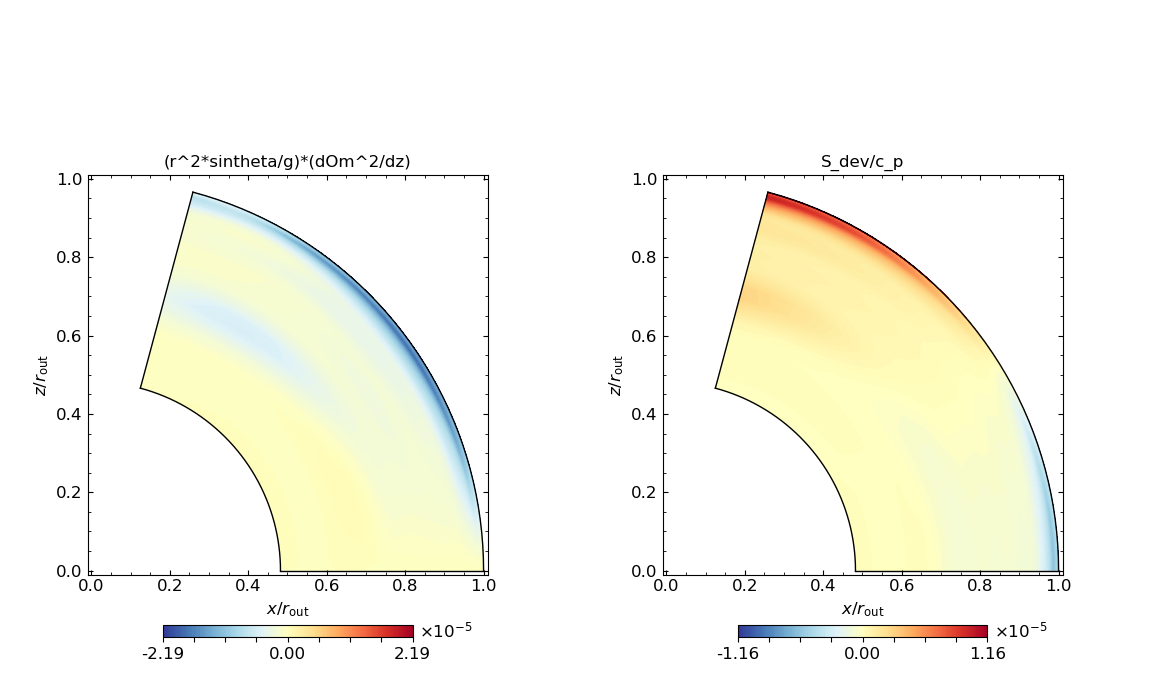

In [18]:
# plot DR derivatives, x r sin theta

# specify any particular "command line arguments" here
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 4, 'ncontours': 20,
                     'nplots': 2, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)

plot_azav (rhs_tw, rr, cost, fig, axs[0,0], **kw_plot_azav)
#kw_plot_azav.minmax = -1e-5, 1e-5
plot_azav (s_dev_nd_tw, rr, cost, fig, axs[0, 1], **kw_plot_azav)

axs[0,0].set_title('(r^2*sintheta/g)*(dOm^2/dz)')
axs[0,1].set_title('S_dev/c_p')

plt.savefig('images/solar_dOm2_sdev_nomean.png', dpi=300)

<IPython.core.display.Javascript object>


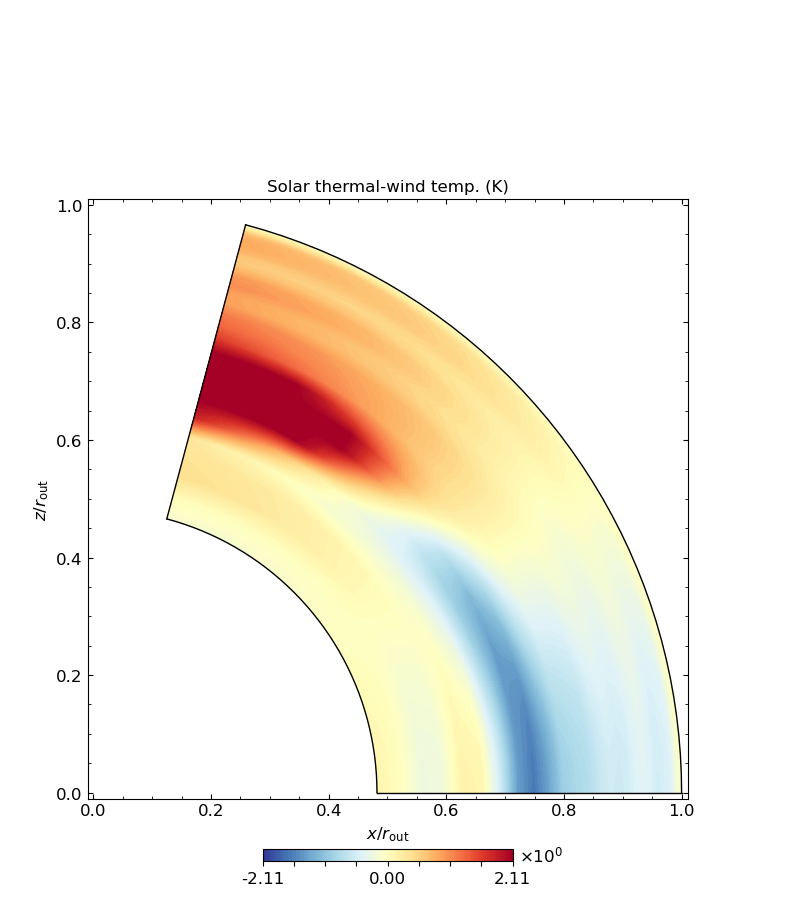

In [19]:
# plot the temperature deviation associated with the thermal wind
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 6, 'ncontours': 20, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]

plot_azav (t_dev_tw, rr, cost, fig, ax, **kw_plot_azav)

ax.set_title("Solar thermal-wind temp. (K)")

plt.savefig('images/solar_TW_temp_nomean.png', dpi=300)

<IPython.core.display.Javascript object>


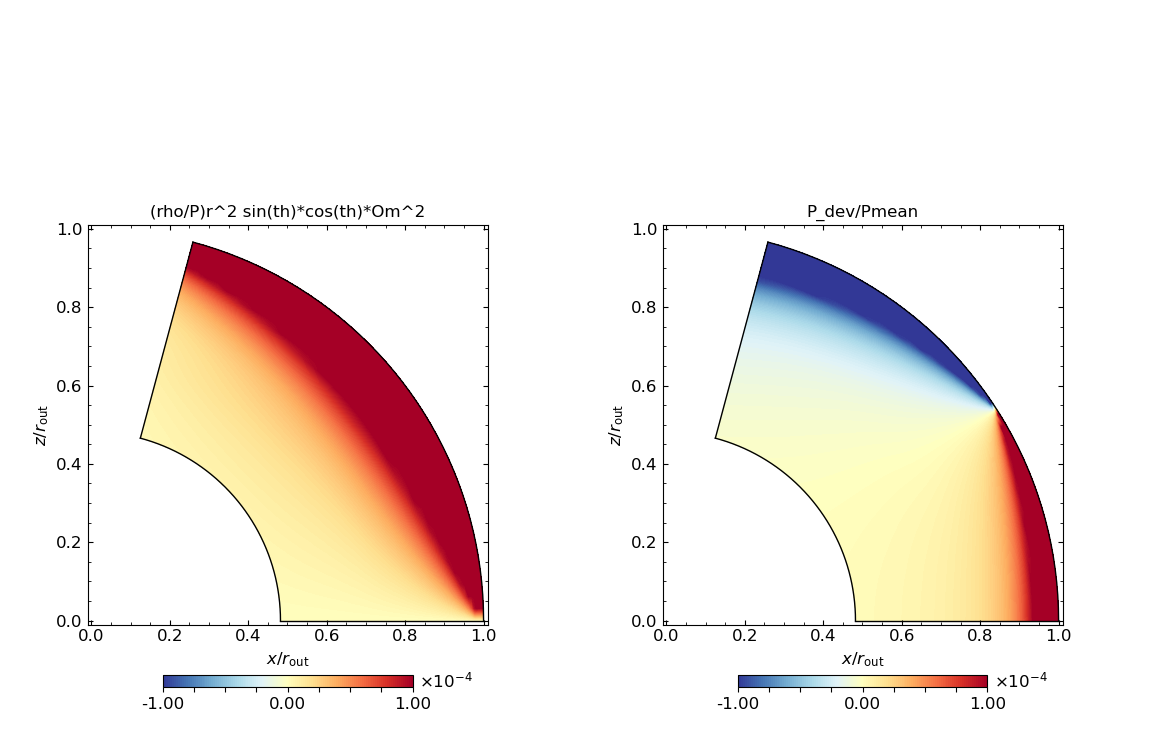

In [20]:
# plot the term affecting pressure perturbations, then the pressure perturbation

# specify any particular "command line arguments" here
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 4, 'ncontours': 20,
                     'nplots': 2, 'plotcontours': False, 'minmax': (-1e-4, 1e-4)})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)

plot_azav (rhs_cent, rr, cost, fig, axs[0,0], **kw_plot_azav)
#kw_plot_azav.minmax = -1e-5, 1e-5
plot_azav (p_dev_nd_cent, rr, cost, fig, axs[0, 1], **kw_plot_azav)

axs[0,0].set_title('(rho/P)r^2 sin(th)*cos(th)*Om^2')
axs[0,1].set_title('P_dev/Pmean')

plt.savefig('images/solar_Om2_pdev_nomean.png', dpi=300)

<IPython.core.display.Javascript object>


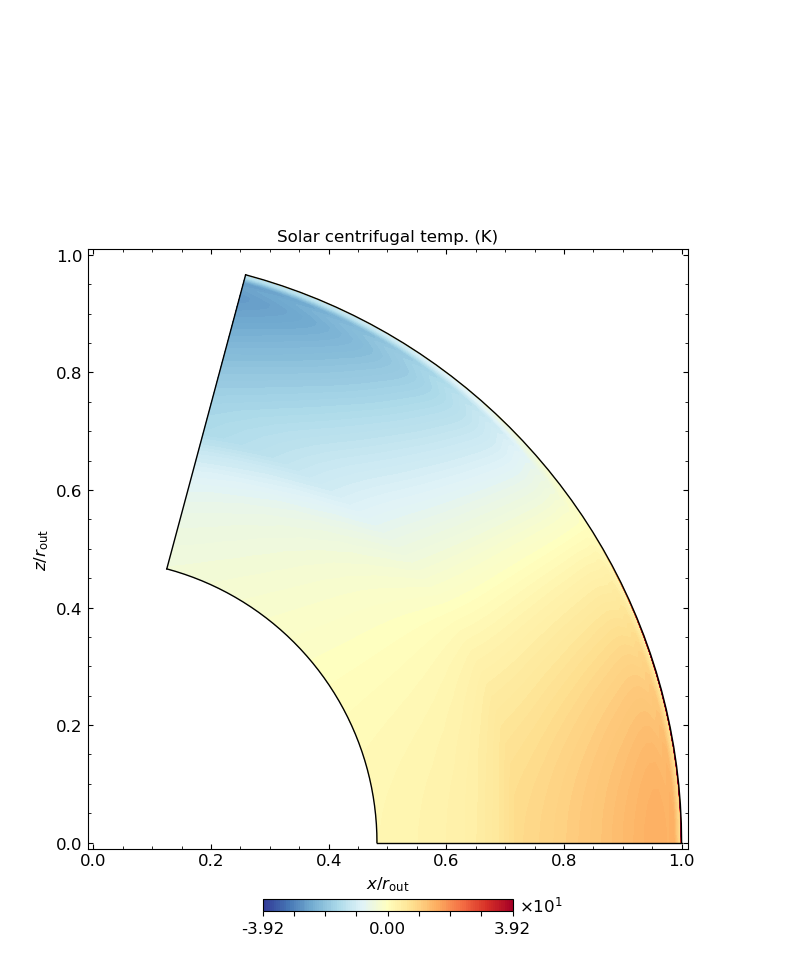

In [21]:
# temp perturbation from centrfigugal force
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 6, 'ncontours': 20, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]

plot_azav (t_dev_cent, rr, cost, fig, ax, **kw_plot_azav)

ax.set_title("Solar centrifugal temp. (K)")

plt.savefig('images/solar_oblateness_temp_nomean.png', dpi=300)

<IPython.core.display.Javascript object>


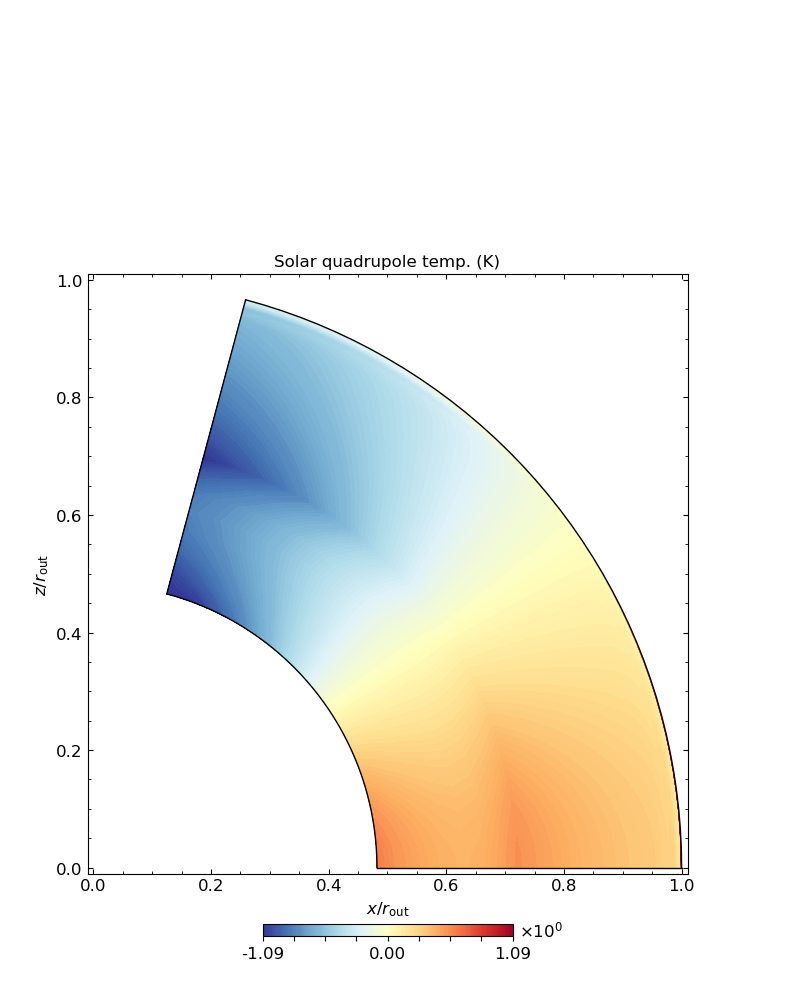

In [22]:
# temp. from quadrupole
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 6, 'ncontours': 20, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]

plot_azav (t_dev_quad, rr, cost, fig, ax, **kw_plot_azav)

ax.set_title("Solar quadrupole temp. (K)")

plt.savefig('images/solar_quad_temp_nomean.png', dpi=300)

In [31]:
# Okay make a decent paper plot, showing all the different temperatures. 
# figure dimensions from scratch
ncol = 3
width_inches = 7 + 1/16
margin_inches = 1/8 # margin width in inches (for both x and y) and 
    # horizontally in between figures
margin_left_inches = 1/2  # label Meridional circulation
margin_right_inches = 1/4
sub_margin_bottom_inches = 1/2
    # larger bottom margin to make room for colorbar
sub_margin_top_inches = 1/4 # wider top title
margin_top_inches = 0 # for overall title

sub_width_inches = (width_inches - (ncol-1)*margin_inches - margin_right_inches - margin_left_inches)/ncol 
sub_height_inches = 1*sub_width_inches

height_inches = 1*(sub_height_inches + sub_margin_bottom_inches + sub_margin_top_inches) + sub_margin_top_inches

# things in "figure units"
margin_x = margin_inches/width_inches
margin_y = margin_inches/height_inches
margin_right = margin_right_inches/width_inches
margin_left = margin_left_inches/width_inches

margin_top = margin_top_inches/height_inches
sub_margin_top = sub_margin_top_inches/height_inches
sub_margin_bottom = sub_margin_bottom_inches/height_inches
sub_width = sub_width_inches/width_inches
sub_height = sub_height_inches/height_inches  

print ("fig size: ", width_inches, height_inches)
print ("az size: ", sub_width_inches, sub_height_inches)

fig size:  7.0625 3.0208333333333335
az size:  2.0208333333333335 2.0208333333333335


In [32]:
# common parameters
fontsize = 7
#fontsize_big = 9
#linecolors = ['m', 'g', 'k']
#linestyles = ['-.', ':', '--']
linecolors = 'k'
linestyles = '--'
#contourstyles = 3*['-'] + ['--'] + 3*['-']
ncontours = 7
cbar_aspect = 1/9
cbar_prec = 1
rvals = np.array([0.695, 0.745, 0.95])*rsun

# print the actual values we come up with for rvals
irvals = inds_from_vals(rr, rvals)
print("rvals actual =", rr[irvals]/rsun)

rvals actual = [0.691917 0.749417 0.947243]


<IPython.core.display.Javascript object>


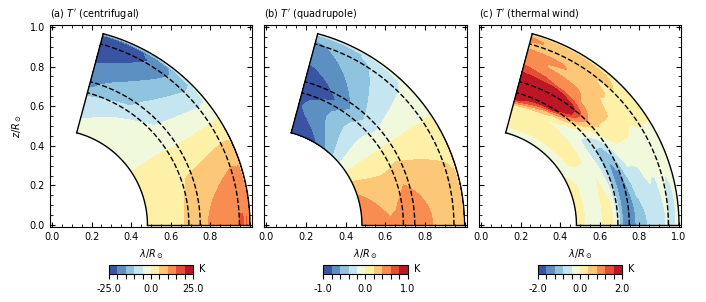

In [33]:
# Generate the actual figure of the correct dimensions
fig = plt.figure(figsize=(width_inches, height_inches))
axs = []


minmaxes = [(-25., 25.), (-1., 1.), (-2., 2.)]

# make subplots
profiles = [t_dev_cent, t_dev_quad, t_dev_tw]
#labels = ['solar centrifugal ' + r'$T^\prime$', 'solar quadrupole ' + r'$T^\prime$', 'solar thermal wind ' + r'$T^\prime$']
labels = [r'$T^\prime$' + ' (centrifugal)',\
          r'$T^\prime$' + ' (quadrupole)', r'$T^\prime$' + ' (thermal wind)']
icol = 0
for icol in range(ncol):
    # diffrot
    ax_left = margin_left + icol*(margin_x + sub_width)
    ax_bottom = 1 - margin_top - sub_margin_top - sub_height
    ax = fig.add_axes((ax_left, ax_bottom, sub_width, sub_height))
    
    profile = profiles[icol]
    plot_azav (profile, rr, cost, fig, ax, halfplane=True, plotaxis=True, nosci=True,\
               cbar_prec=cbar_prec, cbar_thick=3/32, cbar_aspect=cbar_aspect, cbar_fs=fontsize,\
               cbar_offset=3/8,\
               plotlatlines=False, rvals=rvals, linecolors1=linecolors, fontsize=fontsize,\
               linestyles1=linestyles, ncontours=ncontours, plotcontours=False,\
               fullrange2=True, buff_ignore2=0.1, minmax=minmaxes[icol], nlevels=5, units='K')
    

    ax.set_title('(' + letters[icol] + ') ' + labels[icol], fontsize=fontsize, loc='left')


    axs.append(ax)


# replace x axis labels
count = 0
for ax in axs:
    plt.sca(ax)
    ax.set_xlabel(r'$\lambda/R_\odot$', fontsize=fontsize)
    if count == 0:
        ax.set_ylabel(r'$z/R_\odot$', fontsize=fontsize)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        #ax.set_xlim(-.01, 1.01)
    
    # fix x ticks
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    
    # remove last tick label
    if count < 2:
        ticklab = ax.get_xticklabels()
        ticklab[-1] = ''
        ax.set_xticklabels(ticklab)
    count += 1
    
# remove some axis labels


# label sections
#fig.text(margin_x, sub_margin_bottom + 0.5*sub_height,\
#         'meridional circulation: ' + r'$|\hat{\rho}(r)\mathbf{v}_m|$',\
#         rotation=90, ha='left', va='center', fontsize=fontsize_big)

plt.savefig('solar_tmp_anomaly.png', dpi=300)

<IPython.core.display.Javascript object>


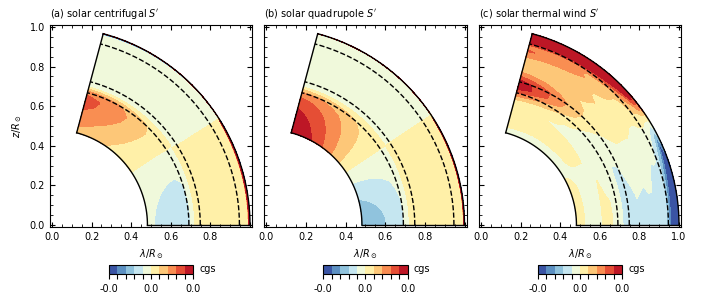

In [35]:
# generate solar entropy anomaly
fig = plt.figure(figsize=(width_inches, height_inches))
axs = []


minmaxes = [None, None, None]
maxabs = [3e-6, 3e-7, 3e-6]
minmaxes = [(-maxabs[0], maxabs[0]), (-maxabs[1], maxabs[1]), (-maxabs[2], maxabs[2])]

# make subplots
profiles = [s_dev_nd_cent, s_dev_nd_quad, s_dev_nd_tw]
labels = ['solar centrifugal ' + r'$S^\prime$', 'solar quadrupole ' + r'$S^\prime$', 'solar thermal wind ' + r'$S^\prime$']

icol = 0
for icol in range(ncol):
    # diffrot
    ax_left = margin_left + icol*(margin_x + sub_width)
    ax_bottom = 1 - margin_top - sub_margin_top - sub_height
    ax = fig.add_axes((ax_left, ax_bottom, sub_width, sub_height))
    
    profile = profiles[icol]
    plot_azav (profile, rr, cost, fig, ax, halfplane=True, plotaxis=True, nosci=True,\
               cbar_prec=cbar_prec, cbar_thick=3/32, cbar_aspect=cbar_aspect, cbar_fs=fontsize,\
               cbar_offset=3/8,\
               plotlatlines=False, rvals=rvals, linecolors1=linecolors, fontsize=fontsize,\
               linestyles1=linestyles, ncontours=ncontours, plotcontours=False,\
               fullrange2=True, buff_ignore2=0.1, minmax=minmaxes[icol], nlevels=5, units='cgs')
    

    ax.set_title('(' + letters[icol] + ') ' + labels[icol], fontsize=fontsize, loc='left')


    axs.append(ax)


# replace x axis labels
count = 0
for ax in axs:
    plt.sca(ax)
    ax.set_xlabel(r'$\lambda/R_\odot$', fontsize=fontsize)
    if count == 0:
        ax.set_ylabel(r'$z/R_\odot$', fontsize=fontsize)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        #ax.set_xlim(-.01, 1.01)
    
    # fix x ticks
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    
    # remove last tick label
    if count < 2:
        ticklab = ax.get_xticklabels()
        ticklab[-1] = ''
        ax.set_xticklabels(ticklab)
    count += 1
    
# remove some axis labels


# label sections
#fig.text(margin_x, sub_margin_bottom + 0.5*sub_height,\
#         'meridional circulation: ' + r'$|\hat{\rho}(r)\mathbf{v}_m|$',\
#         rotation=90, ha='left', va='center', fontsize=fontsize_big)

plt.savefig('solar_s_anomaly.png', dpi=300)

/var/folders/ss/ddlz1pd53ls6zf26gks96rgc0000gp/T/ipykernel_8152/3072986147.py:6: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


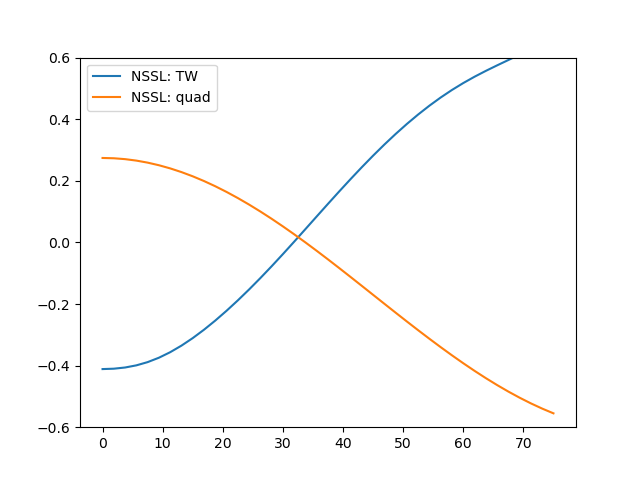

(-0.6, 0.6)

In [36]:
# let's plot thermal wind temp in near surface shear layer
# vs variation from quadrupole

t_dev_tw_nssl = volav_in_radius_loc(t_dev_tw, 0.95*rsun, rsun)
t_dev_quad_nssl = volav_in_radius_loc(t_dev_quad, 0.95*rsun, rsun)
plt.close()
plt.figure()
plt.plot(tt_lat, t_dev_tw_nssl, label='NSSL: TW')
plt.plot(tt_lat, t_dev_quad_nssl, label='NSSL: quad')
plt.legend()
plt.ylim(-0.6, .6)

<IPython.core.display.Javascript object>


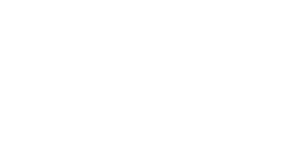

/var/folders/ss/ddlz1pd53ls6zf26gks96rgc0000gp/T/ipykernel_8152/3489851817.py:5: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


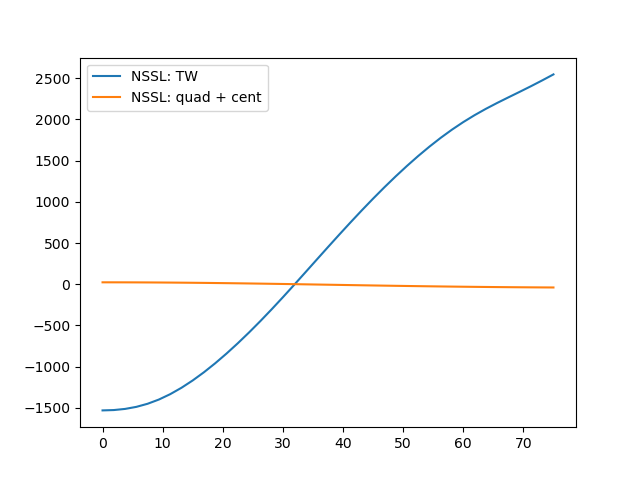

In [37]:
# look at the same thing for S'
plt.figure()
s_dev_tw_nssl = volav_in_radius_loc(s_dev_tw, 0.95*rsun, 0.99*rsun)
s_dev_ob_nssl = volav_in_radius_loc(s_dev_quad+s_dev_cent, 0.95*rsun, 0.99*rsun)
plt.close()
plt.figure()
plt.plot(tt_lat, s_dev_tw_nssl, label='NSSL: TW')
plt.plot(tt_lat, s_dev_ob_nssl, label='NSSL: quad + cent')
plt.legend()
#plt.ylim(-0.6, .6)

<IPython.core.display.Javascript object>


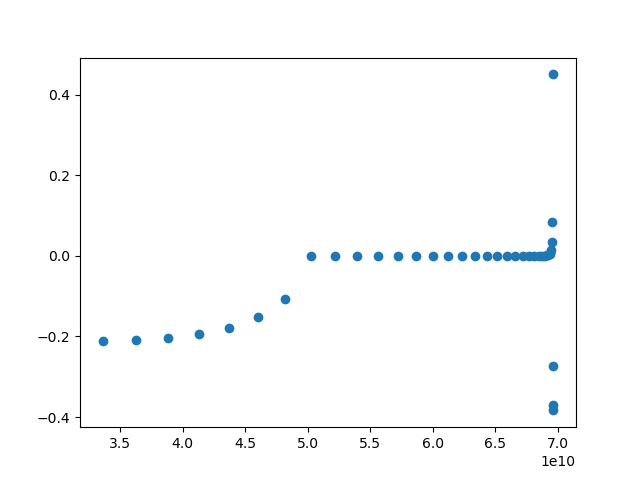

In [38]:
plt.figure()
plt.scatter(rr, dsdp)

In [39]:
# OK, I think we should ignore the entropy gradient from the oblatesss

/var/folders/ss/ddlz1pd53ls6zf26gks96rgc0000gp/T/ipykernel_8152/1252398917.py:3: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


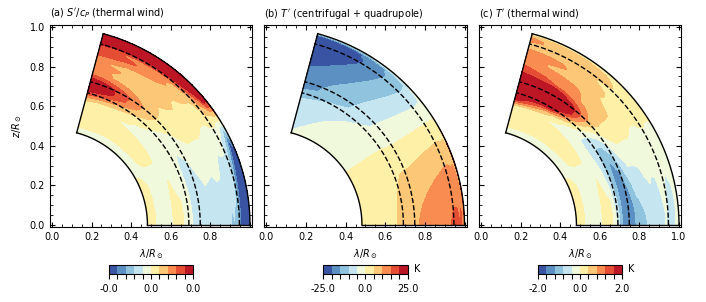

In [41]:
# new figure showing s_dev/c_p, then T from oblateness, T from TW (in K)
# generate solar entropy anomaly
plt.close()
fig = plt.figure(figsize=(width_inches, height_inches))
axs = []


minmaxes = [None, None, None]
minmaxes = [(-2.5e-6, 2.5e-6), (-25., 25.), (-2., 2.)]
nosci = [False, True, True]
units = ['', 'K', 'K']


# make subplots
profiles = [s_dev_nd_tw, t_dev_quad + t_dev_cent, t_dev_tw]
labels = [r'$S^\prime/c_P$' + ' (thermal wind)',\
          r'$T^\prime$' + ' (centrifugal + quadrupole)', r'$T^\prime$' + ' (thermal wind)']

icol = 0
for icol in range(ncol):
    # diffrot
    ax_left = margin_left + icol*(margin_x + sub_width)
    ax_bottom = 1 - margin_top - sub_margin_top - sub_height
    ax = fig.add_axes((ax_left, ax_bottom, sub_width, sub_height))
    
    profile = profiles[icol]
    plot_azav (profile, rr, cost, fig, ax, halfplane=True, plotaxis=True, nosci=True,\
               cbar_prec=cbar_prec, cbar_thick=3/32, cbar_aspect=cbar_aspect, cbar_fs=fontsize,\
               cbar_offset=3/8,\
               plotlatlines=False, rvals=rvals, linecolors1=linecolors, fontsize=fontsize,\
               linestyles1=linestyles, ncontours=ncontours, plotcontours=False,\
               fullrange2=True, buff_ignore2=0.1, minmax=minmaxes[icol], nlevels=5, units=units[icol])
    

    ax.set_title('(' + letters[icol] + ') ' + labels[icol], fontsize=fontsize, loc='left')


    axs.append(ax)


# replace x axis labels
count = 0
for ax in axs:
    plt.sca(ax)
    ax.set_xlabel(r'$\lambda/R_\odot$', fontsize=fontsize)
    if count == 0:
        ax.set_ylabel(r'$z/R_\odot$', fontsize=fontsize)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        #ax.set_xlim(-.01, 1.01)
    
    # fix x ticks
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    
    # remove last tick label
    if count < 2:
        ticklab = ax.get_xticklabels()
        ticklab[-1] = ''
        ax.set_xticklabels(ticklab)
    count += 1
    
# remove some axis labels


# label sections
#fig.text(margin_x, sub_margin_bottom + 0.5*sub_height,\
#         'meridional circulation: ' + r'$|\hat{\rho}(r)\mathbf{v}_m|$',\
#         rotation=90, ha='left', va='center', fontsize=fontsize_big)

plt.savefig('solar_sandt_anomaly.png', dpi=300)

<IPython.core.display.Javascript object>


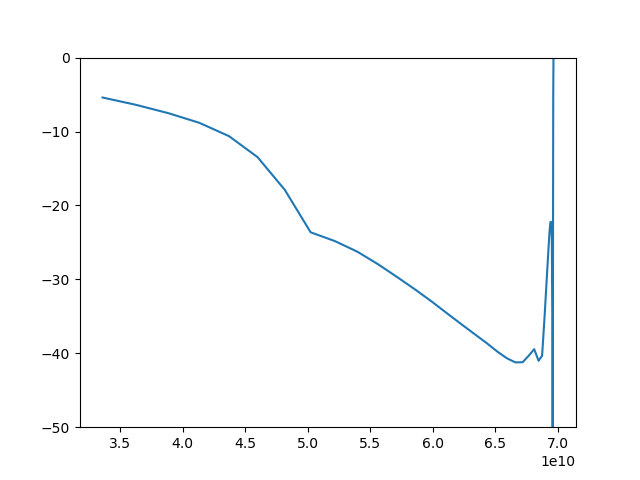

(-50.0, 0.0)

In [42]:
# plot pole to equator difference in temperature
plt.figure()
plt.plot(rr, t_dev_cent[-1, :] - t_dev_cent[0, :])
plt.ylim(-50,0)

<IPython.core.display.Javascript object>


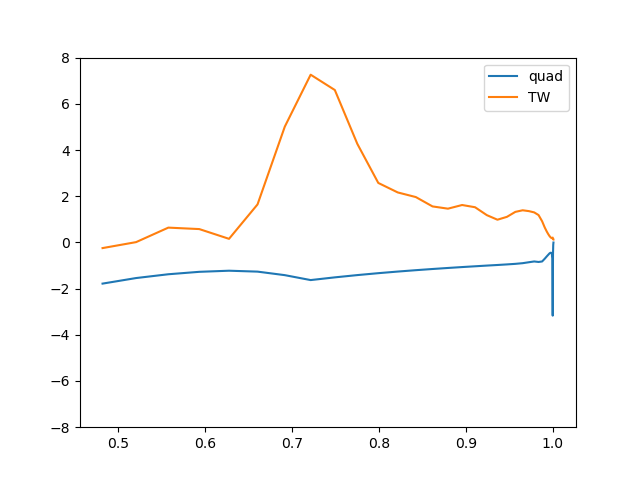

(-8.0, 8.0)

In [43]:
# plot pole to equator difference in temperature
plt.figure()
plt.plot(rr/rsun, t_dev_quad[-1, :] - t_dev_quad[0, :], label='quad')
plt.plot(rr/rsun, t_dev_tw[-1, :] - t_dev_tw[0, :], label='TW')
plt.legend()
plt.ylim(-8,8)

<IPython.core.display.Javascript object>


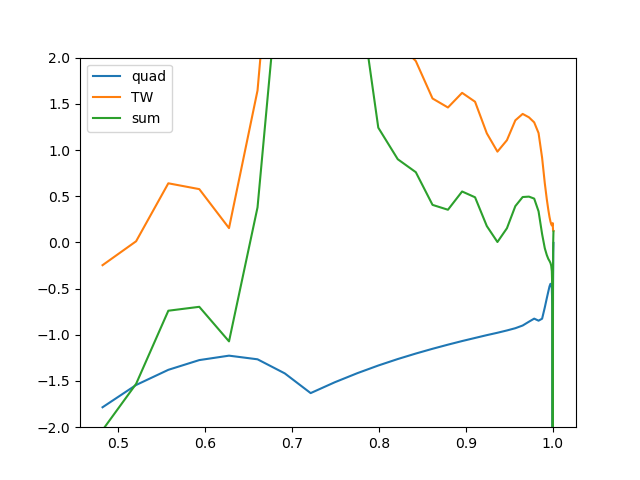

(-2.0, 2.0)

In [44]:
# plot pole to equator difference in temperature
plt.figure()
plt.plot(rr/rsun, t_dev_quad[-1, :] - t_dev_quad[0, :], label='quad')
plt.plot(rr/rsun, t_dev_tw[-1, :] - t_dev_tw[0, :], label='TW')
plt.plot(rr/rsun, t_dev_quad[-1, :] - t_dev_quad[0, :] +t_dev_tw[-1, :] - t_dev_tw[0, :], label='sum' )
plt.legend()
plt.ylim(-2,2)

In [45]:
fontsize = 7
lw_thin = 1

# make line plot for paper with all different terms
# Okay make a decent paper plot, showing all the different temperatures. 
# figure dimensions from scratch
nrow = 2
width_inches = 3 + 7/16
margin_inches = 1/8 # margin width in inches (for both x and y) and 
    # horizontally in between figures
sub_margin_left_inches = 1/2  # y label
sub_margin_right_inches = margin_inches
sub_margin_bottom_inches = 3/8 #(x label)
    # larger bottom margin to make room for colorbar
sub_margin_top_inches = 1/4 # wider top title

sub_width_inches = width_inches - sub_margin_right_inches - sub_margin_left_inches
sub_height_inches = 0.4*sub_width_inches

height_inches = nrow*(sub_height_inches + sub_margin_top_inches) + sub_margin_bottom_inches

# things in "figure units"
margin_x = margin_inches/width_inches
margin_y = margin_inches/height_inches
sub_margin_right = sub_margin_right_inches/width_inches
sub_margin_left = sub_margin_left_inches/width_inches
sub_margin_top = sub_margin_top_inches/height_inches
sub_margin_bottom = sub_margin_bottom_inches/height_inches
sub_width = sub_width_inches/width_inches
sub_height = sub_height_inches/height_inches  

print ("fig size: ", width_inches, height_inches)
print ("az size: ", sub_width_inches, sub_height_inches)

fig size:  3.4375 3.125
az size:  2.8125 1.125


/var/folders/ss/ddlz1pd53ls6zf26gks96rgc0000gp/T/ipykernel_8152/978919385.py:1: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


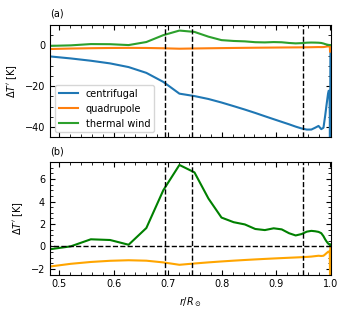

In [46]:
plt.close()
fig = plt.figure(figsize=(width_inches, height_inches))
axs = []

# plot all terms up top
ax_left = sub_margin_left 
ax_bottom = 1 - sub_margin_top - sub_height
ax = fig.add_axes((ax_left, ax_bottom, sub_width, sub_height))
plt.sca(ax)

dt_cent = t_dev_cent[-1, :] - t_dev_cent[0, :]
dt_quad = t_dev_quad[-1, :] - t_dev_quad[0, :]
dt_tw = t_dev_tw[-1, :] - t_dev_tw[0, :]

plt.plot(rr/rsun, dt_cent, label='centrifugal')
plt.plot(rr/rsun, dt_quad, label='quadrupole')
plt.plot(rr/rsun, dt_tw, label='thermal wind')
plt.ylim(-45, 10)
plt.legend(fontsize=fontsize)
#ax.set_xticklabels([])
axs.append(ax)

# then plot smaller terms
ax_left = sub_margin_left 
ax_bottom = 1 - 2*(sub_margin_top + sub_height) #- sub_margin_bottom
ax = fig.add_axes((ax_left, ax_bottom, sub_width, sub_height))
plt.sca(ax)

plt.plot(rr/rsun, dt_quad, label='quadrupole', color='orange')
plt.plot(rr/rsun, dt_tw, label='thermal wind', color='g')
plt.ylim(-2.5, 7.5)
#plt.legend(fontsize=fontsize)
#ax.set_xticklabels([])
axs.append(ax)
# mark zero line
plt.plot(rr/rsun, rr*0, 'k--', linewidth=lw_thin)

count = 0
labels = ['(a)', '(b)']
for ax in axs:
    plt.sca(ax)
    ax.set_xlim(np.min(rr)/rsun, np.max(rr)/rsun)
    plt.minorticks_on()
    plt.tick_params(top=True, left=True, right=True, direction='in', which='both', labelsize=fontsize)
    
    # plot shear layer boundaries
    y1, y2 = ax.get_ylim()
    yrange = np.linspace(y1, y2, 100)
    for xval in rvals/rsun:
        plt.plot(xval + np.zeros(100), yrange, 'k--', linewidth=lw_thin)
    ax.set_ylim(y1, y2)
    # label axes
    if count == 1:
        plt.xlabel(r'$r/R_\odot$', fontsize=fontsize)
    else:
        ax.set_xticklabels([])
    plt.ylabel(r'$\Delta T^\prime$' + ' [K]', fontsize=fontsize)
    
    # label the panels
    fig.text(sub_margin_left, 1 - sub_margin_top + 1/16/height_inches -\
             count*(sub_height + sub_margin_top),\
             labels[count], fontsize=fontsize, ha='left', va='bottom')
    count += 1

plt.savefig('pole_equator_tmp_contrast.png', dpi=300)

rcut =  0.999861


/var/folders/ss/ddlz1pd53ls6zf26gks96rgc0000gp/T/ipykernel_8152/2957818638.py:26: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


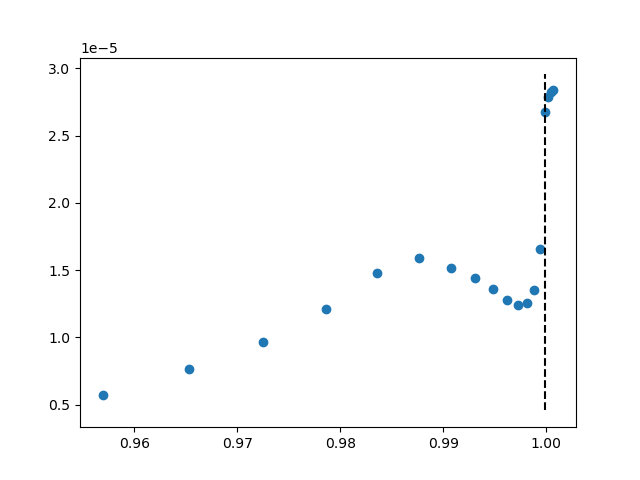

In [47]:

    
# calculate some averages over the bulk tachocline and NSSL
rcut = 1. # ignore weird stuff right at outer surface
def volav_loc(arr):
    out = []
    
    r1, r2 = rvals[0], rvals[1] # tachocline
    ir1, ir2 = inds_from_vals(rr, [r1, r2])
    out.append(np.trapz((arr*rr**2)[ir2:ir1+1], rr[ir2:ir1+1])/np.trapz((rr**2)[ir2:ir1+1], rr[ir2:ir1+1]))

    r1, r2 = rvals[2], rcut*rsun # NSSL
    ir1, ir2 = inds_from_vals(rr, [r1, r2])
    out.append(np.trapz((arr*rr**2)[ir2:ir1+1], rr[ir2:ir1+1])/np.trapz((rr**2)[ir2:ir1+1], rr[ir2:ir1+1]))

    r1, r2 = np.min(rr), np.max(rr) # bulk
    ir1, ir2 = inds_from_vals(rr, [r1, r2])
    out.append(np.trapz((arr*rr**2)[ir2:ir1+1], rr[ir2:ir1+1])/np.trapz((rr**2)[ir2:ir1+1], rr[ir2:ir1+1]))
    
    return np.array(out)

# make sure my choice of rcut is good (although now we integrate, it might not matter)
ircut = np.argmin(np.abs(rr/rsun - rcut))
rcut_actual = rr[ircut]/rsun
print ("rcut = ", rcut_actual)
rcut2 = 0.95 # for plotting purposes only
ircut2 = np.argmin(np.abs(rr/rsun - rcut2))
plt.close()
plt.figure()
plt.scatter(rr[:ircut2]/rsun, (dt_tw/tmp)[:ircut2])
y1, y2 = plt.gca().get_ylim()
yrange = np.linspace(y1, y2, 100)
plt.plot(rcut_actual + np.zeros(100), yrange, 'k--')

In [48]:
print ('cent:', volav_loc(dt_cent))
print ('quad:', volav_loc(dt_quad))
print ('TW:', volav_loc(dt_tw))
print(buff_line)
print ('cent:', volav_loc(dt_cent/tmp)/1e-5)
print ('quad:', volav_loc(dt_quad/tmp)/1e-5)
print ('TW:', volav_loc(dt_tw/tmp)/1e-5)

cent: [-22.57580698 -38.64434585 -27.24041274]
quad: [-1.5495344  -0.82907795 -1.20300213]
TW: [6.55114493 1.07779479 2.16465611]
cent: [ -1.09482431 -57.23410293 -13.89367714]
quad: [-0.07452206 -1.18287079 -0.32543141]
TW: [0.31681061 1.03280916 0.33826449]


In [49]:
rr

array([6.96484779e+10, 6.96310781e+10, 6.96122864e+10, 6.95893883e+10,
       6.95584863e+10, 6.95184669e+10, 6.94687731e+10, 6.94077348e+10,
       6.93323590e+10, 6.92377042e+10, 6.91161147e+10, 6.89563152e+10,
       6.87407669e+10, 6.84568724e+10, 6.81073459e+10, 6.76866891e+10,
       6.71852975e+10, 6.65992734e+10, 6.59272248e+10, 6.51674815e+10,
       6.43180249e+10, 6.33767672e+10, 6.23410635e+10, 6.12083388e+10,
       5.99752522e+10, 5.86382542e+10, 5.71933081e+10, 5.56356811e+10,
       5.39595964e+10, 5.21587207e+10, 5.02255371e+10, 4.81567746e+10,
       4.59759576e+10, 4.36949179e+10, 4.13165787e+10, 3.88404529e+10,
       3.62629212e+10, 3.35780677e+10])

In [50]:
import scipy.integrate as si
print(rr[0]**3/3 - rr[-1]**3/3)
print(np.trapz(rr**2, rr))
print(si.simpson(rr**2, rr))

9.999990286289837e+31
-1.0002161614816586e+32
-1.0000151566329606e+32


In [51]:
# oh that's fine then...

In [52]:
rr[-1]/rsun

0.48245